In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=041a56842e04dd8b107cbf787d17547768695deb586cfa7e731c50c004a77b67
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/demand forecasting")

In [ ]:
os.listdir()

['demand forecasting_pipeline.ipynb',
 'stores.csv',
 'features.csv',
 '.ipynb_checkpoints',
 'test.csv',
 'train.csv',
 'clean_data.csv',
 'walmart_sales_forecast.ipynb']

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("Retail Data Analysis").getOrCreate()

# Load CSV files into PySpark DataFrames
df_store = spark.read.csv('stores.csv', header=True, inferSchema=True)
df_train = spark.read.csv('train.csv', header=True, inferSchema=True)
df_features = spark.read.csv('features.csv', header=True, inferSchema=True)


In [ ]:
df_store.show(5)

+-----+----+------+
|Store|Type|  Size|
+-----+----+------+
|    1|   A|151315|
|    2|   A|202307|
|    3|   B| 37392|
|    4|   A|205863|
|    5|   B| 34875|
+-----+----+------+
only showing top 5 rows



In [ ]:
df_train.show(5)

+-----+----+----------+------------+---------+
|Store|Dept|      Date|Weekly_Sales|IsHoliday|
+-----+----+----------+------------+---------+
|    1|   1|2010-02-05|     24924.5|    false|
|    1|   1|2010-02-12|    46039.49|     true|
|    1|   1|2010-02-19|    41595.55|    false|
|    1|   1|2010-02-26|    19403.54|    false|
|    1|   1|2010-03-05|     21827.9|    false|
+-----+----+----------+------------+---------+
only showing top 5 rows



In [ ]:
df_features.show(5)

+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|Store|      Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|    1|2010-02-05|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    false|
|    1|2010-02-12|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|     true|
|    1|2010-02-19|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|    false|
|    1|2010-02-26|      46.63|     2.561|       NA|       NA|       NA|       NA|       NA|211.3196429|       8.106|    false|
|    1|2010-03-05|       46.5|     2.625|       NA|       NA|       NA|       NA|       NA|211.3501429|       8

In [ ]:
from pyspark.sql.functions import col

# Merge the DataFrames
df = df_train.join(df_features, on=['Store', 'Date'], how='inner')\
             .join(df_store, on=['Store'], how='inner')
df.show(5)


+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+------+
|Store|      Date|Dept|Weekly_Sales|IsHoliday|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|Type|  Size|
+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+------+
|    1|2010-02-05|   1|     24924.5|    false|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    false|   A|151315|
|    1|2010-02-12|   1|    46039.49|     true|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|     true|   A|151315|
|    1|2010-02-19|   1|    41595.55|    false|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|    false|   A|151315

In [ ]:
# Drop duplicated column
df = df.drop('IsHoliday_y')

In [ ]:
# Rename the column
df = df.withColumnRenamed('IsHoliday_x', 'IsHoliday')
df.show()

+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+------+
|Store|      Date|Dept|Weekly_Sales|IsHoliday|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|Type|  Size|
+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+------+
|    1|2010-02-05|   1|     24924.5|    false|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    false|   A|151315|
|    1|2010-02-12|   1|    46039.49|     true|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|     true|   A|151315|
|    1|2010-02-19|   1|    41595.55|    false|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|    false|   A|151315

In [ ]:
# Number of unique values in 'Store'
df.select('Store').distinct().count()

45

In [ ]:
# Number of unique values in 'Dept'
df.select('Dept').distinct().count()

81

In [ ]:
from pyspark.sql.functions import avg

# Average weekly sales for each store and department
store_dept_table = df.groupBy('Store', 'Dept').agg(avg('Weekly_Sales').alias('avg_weekly_sales')).orderBy('Store')
store_dept_table.show()

+-----+----+------------------+
|Store|Dept|  avg_weekly_sales|
+-----+----+------------------+
|    1|  97|  35207.3488111888|
|    1|  41|1064.7696503496497|
|    1|  77|             677.0|
|    1|  52|2355.4393706293704|
|    1|  48|         917.72792|
|    1|  95|120772.06216783212|
|    1|  67| 7436.017342657344|
|    1|  25|10152.336783216784|
|    1|  11|24919.270629370643|
|    1|  20|4091.5715384615382|
|    1|  79| 33974.79293706296|
|    1|  59| 857.7751048951052|
|    1|   4| 36964.15447552445|
|    1|   2| 46102.09041958041|
|    1|  74| 11652.82741258741|
|    1|  81|29780.696573426576|
|    1|  26|6767.9972727272725|
|    1|  22| 8052.076153846147|
|    1|  54| 90.92105263157886|
|    1|  42| 7940.326223776225|
+-----+----+------------------+
only showing top 20 rows



In [ ]:
# Filter rows where Weekly_Sales <= 0
#df_negative_sales = df.filter(df['Weekly_Sales'] <= 0)
df = df.filter(df['Weekly_Sales'] > 0)

In [ ]:
print((df.count(), len(df.columns)))
#dataframe shape

(420212, 17)


In [ ]:
from pyspark.sql.functions import when, col

# Super Bowl dates in the train set
df = df.withColumn('Super_Bowl', when(col('Date').isin(['2010-02-12', '2011-02-11', '2012-02-10']), True).otherwise(False))

# Labor Day dates in the train set
df = df.withColumn('Labor_Day', when(col('Date').isin(['2010-09-10', '2011-09-09', '2012-09-07']), True).otherwise(False))

# Thanksgiving dates in the train set
df = df.withColumn('Thanksgiving', when(col('Date').isin(['2010-11-26', '2011-11-25']), True).otherwise(False))

# Christmas dates in the train set
df = df.withColumn('Christmas', when(col('Date').isin(['2010-12-31', '2011-12-30']), True).otherwise(False))

# Display the updated DataFrame
df.show()

+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+------+----------+---------+------------+---------+
|Store|      Date|Dept|Weekly_Sales|IsHoliday|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|Type|  Size|Super_Bowl|Labor_Day|Thanksgiving|Christmas|
+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+------+----------+---------+------------+---------+
|    1|2010-02-05|   1|     24924.5|    false|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    false|   A|151315|     false|    false|       false|    false|
|    1|2010-02-12|   1|    46039.49|     true|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|     true|  

In [ ]:
from pyspark.sql.functions import avg

# Avg weekly sales for types on Christmas
df.filter(col('Christmas') == True).groupBy('Christmas', 'Type').agg(avg('Weekly_Sales').alias('avg_weekly_sales')).show()

+---------+----+------------------+
|Christmas|Type|  avg_weekly_sales|
+---------+----+------------------+
|     true|   A|18310.167534699263|
|     true|   B| 11488.98805676855|
|     true|   C| 8031.520607082625|
+---------+----+------------------+



In [ ]:
# Avg weekly sales for types on Labor Day
df.filter(col('Labor_Day') == True).groupBy('Labor_Day', 'Type').agg(avg('Weekly_Sales').alias('avg_weekly_sales')).show()

+---------+----+-----------------+
|Labor_Day|Type| avg_weekly_sales|
+---------+----+-----------------+
|     true|   A|20004.26742233972|
|     true|   B|12084.30464159811|
|     true|   C|  9893.4592575928|
+---------+----+-----------------+



In [ ]:
# Avg weekly sales for types on Thanksgiving
df.filter(col('Thanksgiving') == True).groupBy('Thanksgiving', 'Type').agg(avg('Weekly_Sales').alias('avg_weekly_sales')).show()

+------------+----+------------------+
|Thanksgiving|Type|  avg_weekly_sales|
+------------+----+------------------+
|        true|   A|27397.776345711474|
|        true|   B| 18733.97397058824|
|        true|   C|  9696.56661590524|
+------------+----+------------------+



In [ ]:
# Avg weekly sales for types on Super Bowl
df.filter(col('Super_Bowl') == True).groupBy('Super_Bowl', 'Type').agg(avg('Weekly_Sales').alias('avg_weekly_sales')).show()

+----------+----+------------------+
|Super_Bowl|Type|  avg_weekly_sales|
+----------+----+------------------+
|      true|   A|20612.757673550062|
|      true|   B|12467.035505813967|
|      true|   C|10179.271884222479|
+----------+----+------------------+



In [ ]:
# Avg weekly sales for IsHoliday
#df.groupBy(df['IsHoliday']).agg(avg('Weekly_Sales').alias('avg_weekly_sales')).show()

In [ ]:
# Sort DataFrame by Weekly_Sales
df.orderBy(df['Weekly_Sales'].desc()).show(5)

+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+------+----------+---------+------------+---------+
|Store|      Date|Dept|Weekly_Sales|IsHoliday|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|Type|  Size|Super_Bowl|Labor_Day|Thanksgiving|Christmas|
+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+------+----------+---------+------------+---------+
|   10|2010-11-26|  72|   693099.36|     true|      55.33|     3.162|       NA|       NA|       NA|       NA|       NA|126.6692667|       9.003|     true|   B|126512|     false|    false|        true|    false|
|   35|2011-11-25|  72|   649770.18|     true|      47.88|     3.492|  1333.24|       NA| 58563.24|    20.97|  6386.86|140.4217857|       8.745|     true|  

In [ ]:
# GroupBy and Describe Size by Type
df_store.groupBy('Type').agg({'Size': 'avg'}).show()

+----+------------------+
|Type|         avg(Size)|
+----+------------------+
|   B|101190.70588235294|
|   C|40541.666666666664|
|   A|177247.72727272726|
+----+------------------+



In [ ]:
from pyspark.sql.functions import isnan, when, count, col

# Check for duplicate column names
duplicate_cols = [col for col in df.columns if df.columns.count(col) > 1]
if duplicate_cols:
    print("Duplicate columns found:", duplicate_cols)
    # Handle duplicate columns (e.g., rename, drop, etc.)

# Check for missing values in all columns
#df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

Duplicate columns found: ['IsHoliday', 'IsHoliday']


AnalysisException: [AMBIGUOUS_REFERENCE] Reference `IsHoliday` is ambiguous, could be: [`IsHoliday`, `IsHoliday`].

In [ ]:
# Fill missing values with 0
df = df.fillna(0)

# Check again for missing values
#df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


AnalysisException: [AMBIGUOUS_REFERENCE] Reference `IsHoliday` is ambiguous, could be: [`IsHoliday`, `IsHoliday`].

In [ ]:
from pyspark.sql.functions import to_date, weekofyear, month, year

# Convert to datetime and extract week, month, year
df = df.withColumn('Date', to_date('Date'))\
       .withColumn('week', weekofyear('Date'))\
       .withColumn('month', month('Date'))\
       .withColumn('year', year('Date'))


In [ ]:
# GroupBy month and get average Weekly_Sales
df.groupBy('month').agg(avg('Weekly_Sales').alias('avg_weekly_sales')).show()


+-----+------------------+
|month|  avg_weekly_sales|
+-----+------------------+
|   12| 19425.79860279511|
|    1|14182.239153163864|
|    6|16397.605477864687|
|    3| 15464.81769800685|
|    5| 15845.55619965867|
|    9|15147.216062549078|
|    4|15696.435193273635|
|    8|16113.800068860337|
|    7|15905.472424939482|
|   10| 15279.18211945447|
|   11|17534.964277405124|
|    2| 16048.70119137651|
+-----+------------------+



In [ ]:
# GroupBy year and get average Weekly_Sales
df.groupBy('year').agg(avg('Weekly_Sales').alias('avg_weekly_sales')).show()


+----+------------------+
|year|  avg_weekly_sales|
+----+------------------+
|2012|15748.265005196645|
|2010|16318.648284806179|
|2011|16007.797985288578|
+----+------------------+



In [ ]:
df.show()


+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+------+----------+---------+------------+---------+----+-----+----+
|Store|      Date|Dept|Weekly_Sales|IsHoliday|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|Type|  Size|Super_Bowl|Labor_Day|Thanksgiving|Christmas|week|month|year|
+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+----+------+----------+---------+------------+---------+----+-----+----+
|    1|2010-02-05|   1|     24924.5|    false|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    false|   A|151315|     false|    false|       false|    false|   5|    2|2010|
|    1|2010-02-12|   1|    46039.49|     true|      38.51|     2.548|       NA|       NA|   

In [ ]:
# Save the cleaned DataFrame to CSV
df = df.drop('isholiday_old')
df.write.csv('clean_data_pipe.csv', header=True)


## **visualizing**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

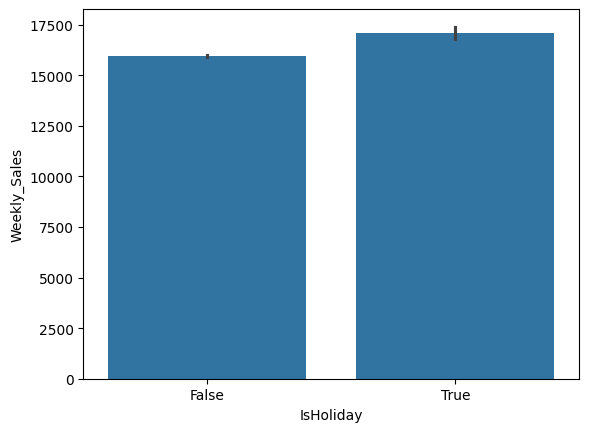

In [ ]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)#cocnclusion: while holiday more sales

All holidays are not in the data. There are 4 holiday values such as: Super Bowl, Labor Day, Thanksgiving, Christmas

In [ ]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [ ]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique()

133

In [ ]:
#to see differences between holiday types. create new columns for 4 types of holidays and fill them with boolean values. If date belongs to this type of holiday it is True, if not False.
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

In [ ]:
#There are three different store types in the data as A, B and C.
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Christmas

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [ ]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Labor Day

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [ ]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Thanksgivingd

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [ ]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Super Bowl

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

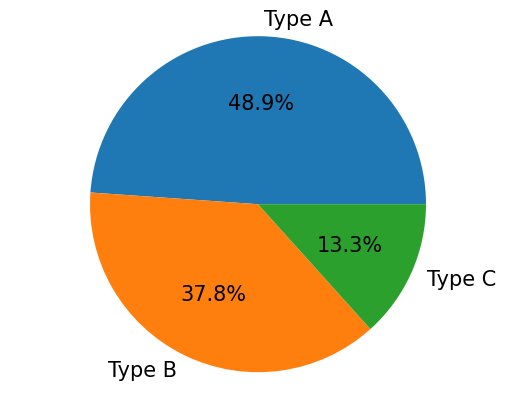

In [ ]:
#percentages of store types.
my_data = [48.88, 37.77 , 13.33 ]  #percentages
my_labels = 'Type A','Type B', 'Type C' # labels
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels

plt.show()

In [ ]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

<ipython-input-30-985733ab0b41>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


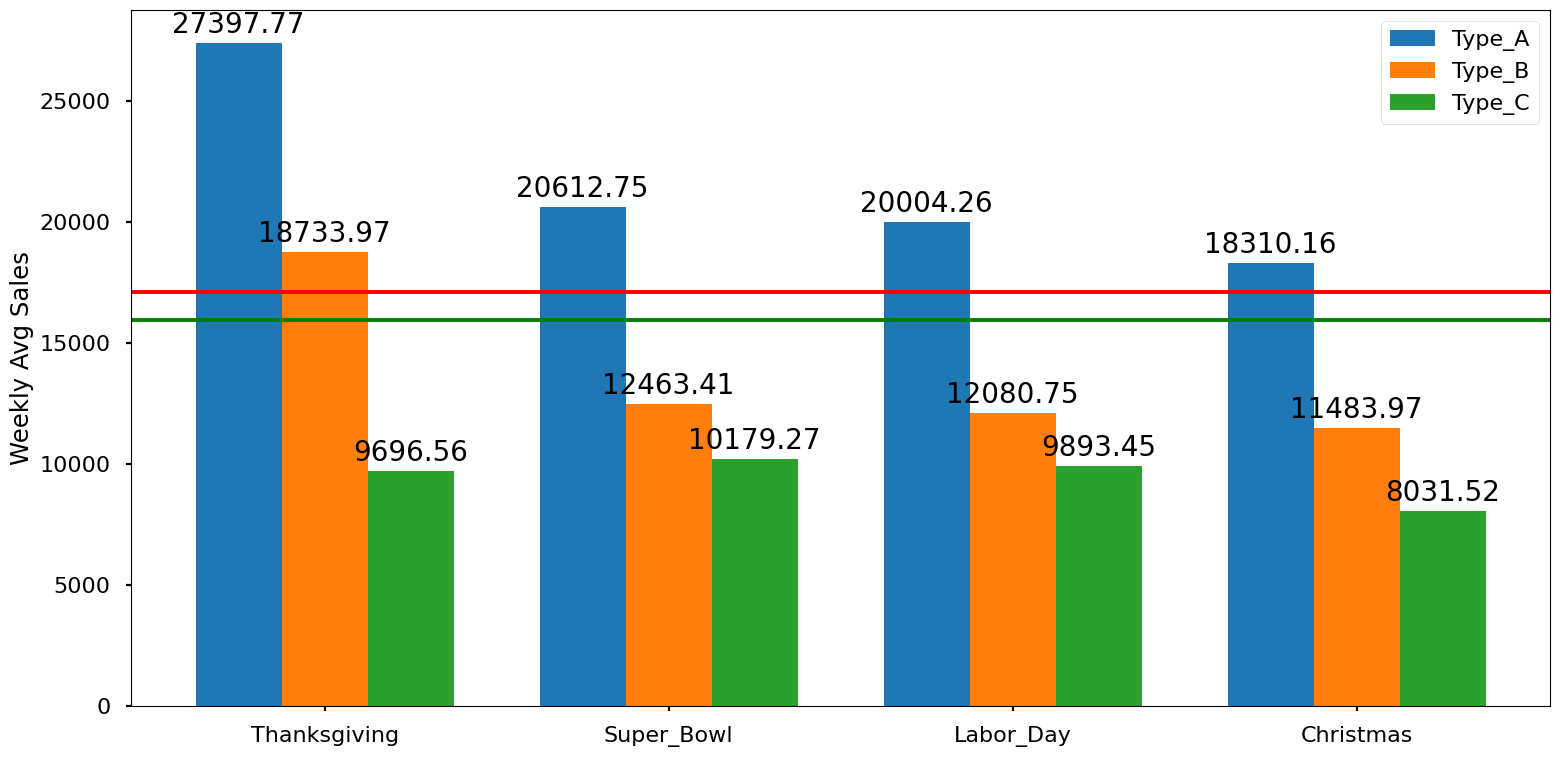

In [ ]:
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.82,color='green') # not-holiday avg

fig.tight_layout()

plt.show()

In [ ]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

NameError: name 'df' is not defined

In [ ]:
#To See the Size - Type Relation
df_store.groupby('Type').describe()['Size'].round(2)

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


Markdown Columns¶
Walmart gave markdown columns to see the effect if markdowns on sales.

In [ ]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [ ]:
df = df.fillna(0)

In [ ]:
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [ ]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


Changing Date to Datetime and Creating New Columns

In [ ]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df["week"] = df['Date'].dt.isocalendar().week
df['month'] =df['Date'].dt.month
df['year'] =df['Date'].dt.year

In [ ]:
df.groupby('month')['Weekly_Sales'].mean()

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [ ]:
df.groupby('year')['Weekly_Sales'].mean()

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='month'>

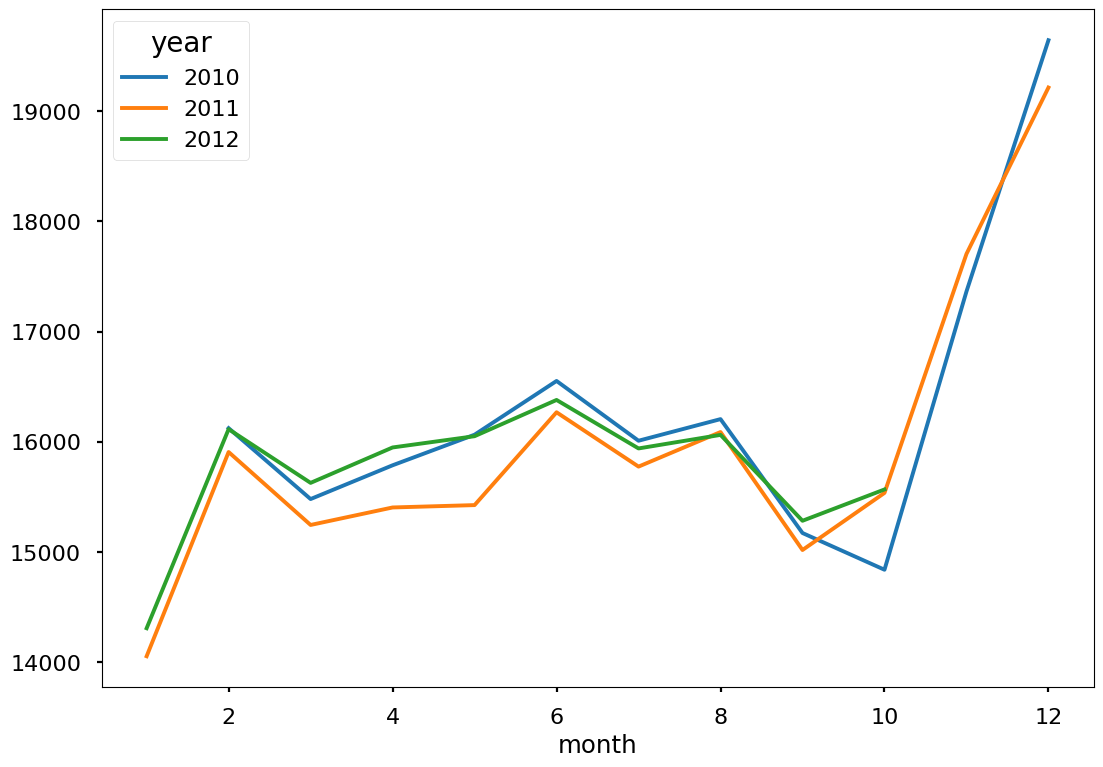

In [ ]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

In [ ]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='week'>

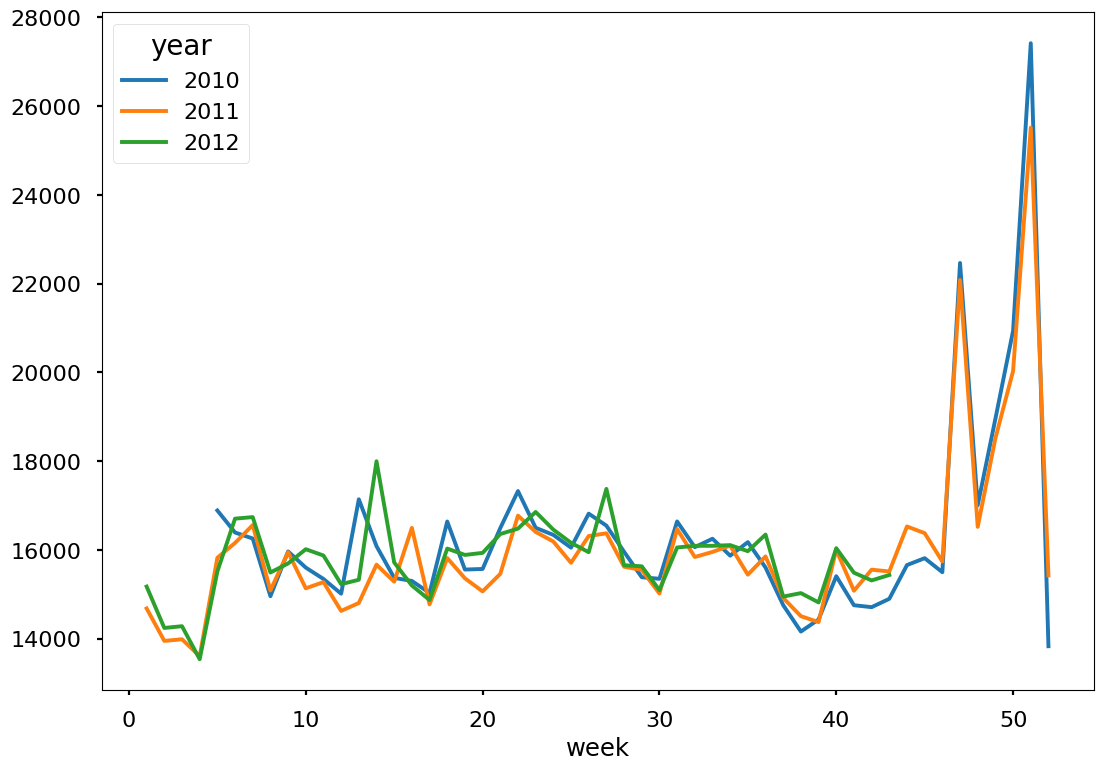

In [ ]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

Fuel Price, CPI , Unemployment , Temperature Effects

In [ ]:
pd.options.display.max_columns=100

In [ ]:
#df.to_csv('clean_data.csv')

In [ ]:
df = pd.read_csv('./clean_data__pipeline.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
#df['Date'] = pd.to_datetime(df['Date'])

## encoding data

In [ ]:
df_encoded = df.copy() # to keep original dataframe taking copy of it
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original

In [ ]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True)

In [ ]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True)

In [ ]:
df_new = df_new.sort_values(by='Date', ascending=True)

## train test split

In [ ]:
df_encoded_new = df_encoded.copy() # taking copy of encoded data to keep it without change.
df_encoded_new.drop(drop_col, axis=1, inplace=True)

In [ ]:
#train-test splitting
train_data_enc_new = df_encoded_new[:int(0.7*(len(df_encoded_new)))]
test_data_enc_new = df_encoded_new[int(0.7*(len(df_encoded_new))):]

target = "Weekly_Sales"
used_cols2 = [c for c in df_encoded_new.columns.to_list() if c not in [target]] # all columns except price

X_train_enc1 = train_data_enc_new[used_cols2]
X_test_enc1 = test_data_enc_new[used_cols2]
y_train_enc1 = train_data_enc_new[target]
y_test_enc1 = test_data_enc_new[target]

#droping date from train-test
X_train_enc1 = X_train_enc1.drop(['Date'], axis=1)
X_test_enc1= X_test_enc1.drop(['Date'], axis=1)

# metric definition function

In [ ]:
def wmae_test(test, pred): # WMAE for test
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

## Model

In [ ]:
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:00


In [ ]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) #seting date as index

In [ ]:
print(df.dtypes)

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Type             object
Size              int64
Super_Bowl         bool
Labor_Day          bool
Thanksgiving       bool
Christmas          bool
week              int64
month             int64
year              int64
dtype: object


In [ ]:
df_week = df.resample('W').apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

In [ ]:
train_data = df_week[:int(0.7*(len(df_week)))]
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)


Train: (100, 22)
Test: (43, 22)


In [ ]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna()

train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [ ]:
model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

In [ ]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])

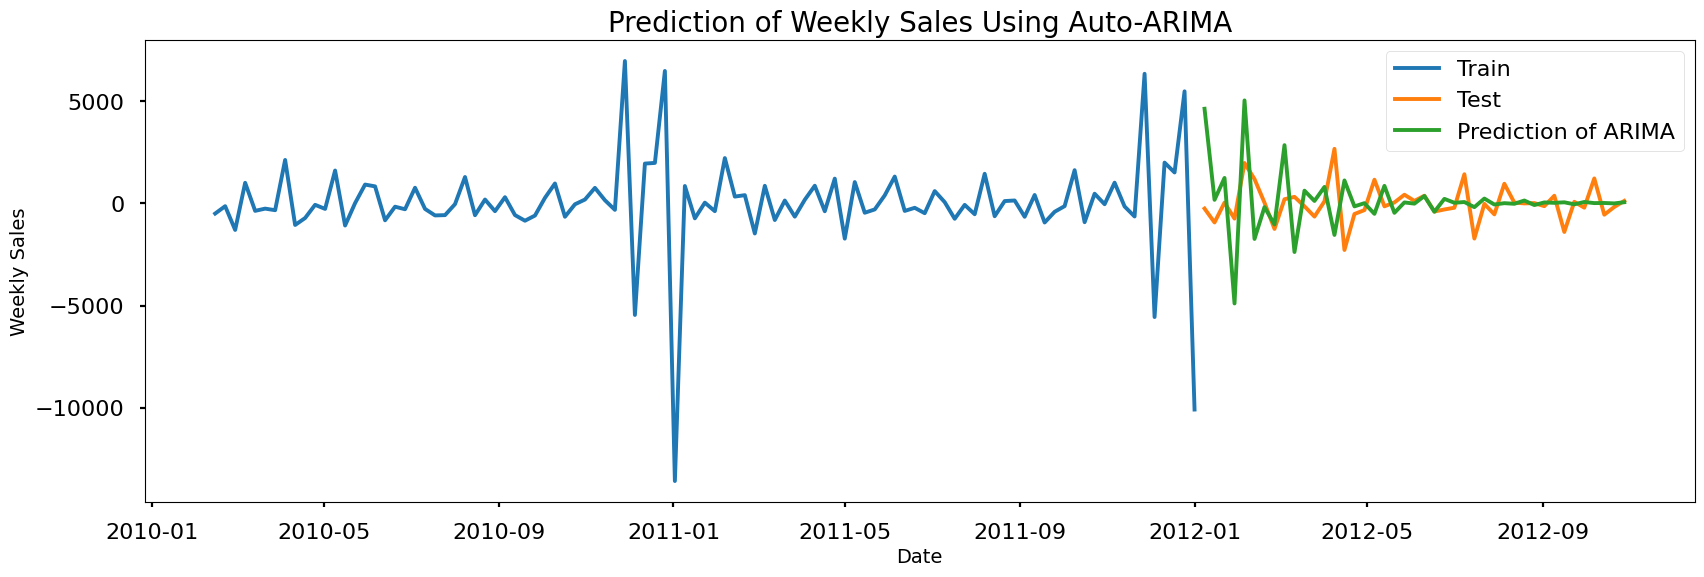

In [ ]:

plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()